<a href="https://colab.research.google.com/github/monikamikhaiel/graduation-project-/blob/main/Multiple_Antennas_shifting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np  # for array stuff and random
import matplotlib.pyplot as plt  # for graphing our mean rewards over time
from matplotlib import style  # to make pretty charts because it matters.
import time  # using this to keep track of our saved Q-Tables.
import cv2

style.use("ggplot")  # setting our style!

In [ ]:
# area
#im = cv2.imread('/content/room.jpg')
#width = int(im.shape[1] * 50 / 100)
#height = int(im.shape[0] * 50 / 100)

# dsize
#dsize = (width, height)

# resize image
#output = cv2.resize(im, dsize)

#print(im.shape)
SIZE_W = 5
SIZE_H = 5
print(SIZE_H,SIZE_W)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

5 5


In [ ]:
HM_EPISODES = 2500
epsilon = 0.5  # randomness
EPS_DECAY = 0.9999  # Every episode will be epsilon*EPS_DECAY
SHOW_EVERY = 100  # how often to play through env visually.

start_q_table = None  # if we have a pickled Q table, we'll put the filename of it here.

LEARNING_RATE = 0.1
DISCOUNT = 0.95

ANTENNA_N = 5  # NUMBER OF ANTENNAS 

# the dict! Using just for colors
d = {1: (255, 175, 0) }  # Antenna color blue
#SNR RANGES
snr_range={"highSNR_max":-50,"highSNR_min":-80,
           "mediumSNR_max":-90,"mediumSNR_min":-100,
          "deadzone":-120}

In [ ]:
#antenna
class antenna:
    def __init__(self):
        self.x = np.random.randint(0, SIZE_W)
        self.y = np.random.randint(0, SIZE_H)
    def __str__(self):
        return f"{self.x}, {self.y}"
    def __sub__(self, other):
        return (self.x-other.x, self.y-other.y)
    def action(self, choice):
        '''
        Gives us 4 total movement options. (0,1,2,3)
        '''
        if choice == 0:  #up
            #self.move(x=0, y=1)
            self.x=self.x
            self.y+=1
            self.move()

        elif choice == 1:  #down
            #self.move(x=0, y=-1)
            self.x=self.x
            self.y-=1
            self.move()

        elif choice == 2:  #left
           # self.move(x=-1, y=0)
            self.x-=1
            self.y=self.y
            self.move()

        elif choice == 3:    #right
            # self.move(x=1, y=0)
            self.x+=1
            self.y=self.y
            self.move()

#    def move(self, x=False, y=False):
    def move(self):
        # If no value for x, move randomly
      #  if not x:
      #      self.x += np.random.randint(-1, 2)
       # elif x==0:
      #      self.x=self.x
      #  else:
       #     self.x += x

        # If no value for y, move randomly
       # if not y:
        #    self.y += np.random.randint(-1, 2)
       # elif y==0:
        #    self.y=self.y
       # else:
        #    self.y += y
      # If we are out of bounds, fix!
        if self.x < 0:
            self.x = 0
        elif self.x > SIZE_W-1:
            self.x = SIZE_W-1
        if self.y < 0:
            self.y = 0
        elif self.y > SIZE_H-1:
            self.y = SIZE_H-1



In [ ]:
ant = antenna()
print(ant)
ant.action(0) # up
print(ant)
ant.action(1) #down 
print(ant)
ant.action(2) #left
print(ant)
ant.action(3) #right 
print(ant)


1, 0
1, 1
1, 0
0, 0
1, 0


In [ ]:
x = SIZE_W # Building X
y = SIZE_H # Building Y
z = 4 # actions

q_table = np.zeros((x, y, z))
# q_table *= 0
print(q_table.shape)


(5, 5, 4)


In [ ]:
#okomora model 
def okomora(ant,SIZE_H,SIZE_W):
  PathLoss=[]
  attenuation= 13 #in db function of frequency and distance 
  freq= 2.4*(10^9) # the frequency og the signal
  c= 3*(10^8) # the speed of light
  #hte = input("please enter the height of the transmitter antenna ? ")
  #hre = input("please enter the height of the receiver antenna ? ")
  hte= 20
  hre= 2
  G_hte = 10*np.log(int(hte) /200) 
  G_hre = 10*np.log(int(hre)/ 3)
  G_Area =27 # (Quasi Open Area)
  for i in range(SIZE_H):
    for j in range(SIZE_W):
      difference = [ant.x-i,ant.y-j]
      if difference == [0,0]:
        continue
      else:
        ## calculate the pathloss
        distance=pow((pow(difference[0],2)+pow(difference[1],2)),0.5)
        FPL      = 20*np.log(4*np.pi*distance*freq/c)
        Path_Loss = FPL + attenuation - G_hte - G_hre - G_Area
        PathLoss.append(Path_Loss)
  return PathLoss  
#len(okomora(ant,SIZE_H,SIZE_W))

In [ ]:
def AnglesInDegrees(ant,SIZE_H,SIZE_W):
  theta=[]
  for i in range(SIZE_H):
    for j in range(SIZE_W):
      difference = [ant.x-i,ant.y-j]
      if difference==[0,0]: # the same position as the antenna 
        continue
      if difference[0]==0:     # the angle itself is either 90 or 270 tan will be infinite 
          if difference[1]>0:
            t=90
            theta.append(90)
          else:
            t=270
            theta.append(270)
      else:
          tantheta= difference[1]/difference[0]
          t=np.degrees(np.arctan(tantheta))
          if t <=0:
            t+=360
            theta.append(t)
          else:
            theta.append(t)
  return theta
#print(len(AnglesInDegrees(ant,SIZE_H,SIZE_W)))

In [ ]:
def measureSNR(ant,SIZE_H,SIZE_W,type="omnidirectionnel"):
  Path_Loss=okomora(ant,SIZE_H,SIZE_W)
  Gain=[]
  if type == "omnidirectionnel" :
    Gain_pannel=7 #in db
    for i in range(len(Path_Loss)):
      Gain.append(Gain_pannel-Path_Loss[i])
  elif type== "directionnel":
    thetas=AnglesInDegrees(ant,SIZE_H,SIZE_W)
    GainVsTheta={360:-20,30:-10,60:-5,90:15,120:0,150:-10,180:-20,210:-10,240:-8,270:-15,300:-8,330:-10} # values in db angle:gain
    for i in range(len(thetas)):
      t=thetas[i]
      if t==0:
       value = GainVsTheta[360]
      elif t<=30:
        value = GainVsTheta[30]
      elif 30<t<=60:
        value = GainVsTheta[60]
      elif 60<t<=90:
        value = GainVsTheta[90]
      elif 90<t<=120:
        value = GainVsTheta[120]
      elif 120<t<=150:
        value = GainVsTheta[150]
      elif 150<t<=180:
        value = GainVsTheta[180]
      elif 180<t<=210:
        value = GainVsTheta[210]
      elif 210<t<=240:
        value = GainVsTheta[240]
      elif 240<t<=270:
        value = GainVsTheta[270]
      elif 270<t<=300:
        value = GainVsTheta[300]
      elif 300<t<=330:
        value = GainVsTheta[330]
      elif 330<t<=360:
        value = GainVsTheta[360]
      Gain.append(value-Path_Loss[i])
  Magnitude=[]
  for g in Gain:
    mag=pow(10,(g/10))
    Magnitude.append(mag)
  return Magnitude
#measureSNR(ant,SIZE_H,SIZE_W,type="omnidirectionnel")


In [ ]:
def SplitArea(ANTENNA_N,SIZE_H,SIZE_W):
  Coordinates=[]
  area=SIZE_H*SIZE_w
  newArea= area/ANTENNA_N
  Coordinates.append()
  number_of_qtables=  ANTENNA_N
for number_of_qtables in range (ANTENNA_N):
    xn = SIZE_W # Building X
    yn = SIZE_H # Building Y
    z = 4 # actions

    q_table = np.zeros((x, y, z))
# q_table *= 0
print(q_table.shape)
    

(5, 5, 4)


In [ ]:
def calSNRlow(SNR):
  counter =0
  for i in range(len(SNR)):
    if int(SNR[i]) < snr_range["deadzone"]:
      counter+=1
      percent=counter*100/len(SNR)
    #return percent
  return np.mean(SNR)
calSNRlow(measureSNR (ant,SIZE_H,SIZE_W))

1.3886250977364015e-07

In [ ]:

episode_rewards = []
reward=0
for episode in range(HM_EPISODES):
    ant = antenna()
    if episode % SHOW_EVERY == 0:
        print(f"on #{episode}")
       # print(f"{SHOW_EVERY} ep mean: {np.mean(episode_rewards[-SHOW_EVERY:])}")
        show = True
    else:
        show = False

    episode_reward = 0
    state=0
    for i in range(200):
        antennaPos = (ant) # Current Antenna X, Y Co-ord.

        if np.random.random() > epsilon:
            # GET THE ACTION
#             if state <=25:
#                 state=0
#             else:
#                 state+=1

            action = np.argmax(q_table[ant.x][ant.y])
        else:
            action = np.random.randint(0, 4) #low is inclusive high is exclusive 
            #print(action)
        # Take the action!
        ant.action(action) # move the  antenna
        ###
        #calculate the SNR
        snr=measureSNR(ant,SIZE_H,SIZE_W,type="omnidirectionnel")
        percent=calSNRlow(snr)
        ##
        reward=percent
          ###
        #current_q = q_table[state][action]
        newAntennaPos = (ant)
        current_q = q_table[ant.x][ant.y][action] # Current State
        max_future_q = np.max(q_table[ant.x][ant.y]) # Max State
        new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
        q_table[ant.x][ant.y][action] = new_q
      

        episode_reward += reward

        #print(episode_reward)
    episode_rewards.append(episode_reward)
    epsilon *= EPS_DECAY

on #0
on #100
on #200
on #300
on #400
on #500
on #600
on #700
on #800
on #900
on #1000
on #1100
on #1200
on #1300
on #1400
on #1500
on #1600
on #1700
on #1800
on #1900
on #2000
on #2100
on #2200
on #2300
on #2400


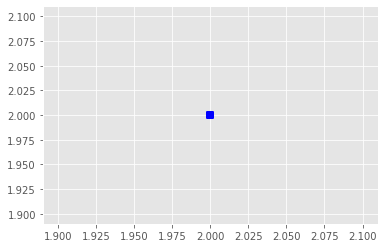

In [ ]:
xval=[]
yval=[]
max_value =np.max((q_table))
#print(max_value)
for i in range(SIZE_H):
  for j in range(SIZE_W):
    for k in range(4):
      if max_value  == (q_table[i][j][k]):
        xval.append(i)
        yval.append(j)
      else :
        continue
#outputOfTraining(q_table)
 
plt.scatter(xval, yval, color= "blue", linewidths =2 ,marker ="s")
plt.show()



In [ ]:
def TrainingFunction(epsilon,EPS_DECAY,HM_EPISODES,SIZE_H,SIZE_W,type_="omnidirectionnel"):
  #initialize q table
  x = SIZE_W # Building X
  y = SIZE_H # Building Y
  z = 4 # actions
  q_table = np.zeros((x, y, z))
  episode_rewards = []
  reward=0
  for episode in range(HM_EPISODES):
      ant = antenna()
      if episode % SHOW_EVERY == 0:
          print(f"on #{episode}")
       # print(f"{SHOW_EVERY} ep mean: {np.mean(episode_rewards[-SHOW_EVERY:])}")
          show = True
      else:
          show = False

      episode_reward = 0
      state=0
      for i in range(200):
          antennaPos = (ant) # Current Antenna X, Y Co-ord.

          if np.random.random() > epsilon:
            # GET THE ACTION
#             if state <=25:
#                 state=0
#             else:
#                 state+=1

              action = np.argmax(q_table[ant.x][ant.y])
          else:
              action = np.random.randint(0, 4) #low is inclusive high is exclusive 
          #print(action)
        # Take the action!
          ant.action(action) # move the  antenna
        ###
        #calculate the SNR
          snr=measureSNR(ant,SIZE_H,SIZE_W,type_)
          percent=calSNRlow(snr)
        ##
          reward=percent
          ###
        #current_q = q_table[state][action]
          newAntennaPos = (ant)
          current_q = q_table[ant.x][ant.y][action] # Current State
          max_future_q = np.max(q_table[ant.x][ant.y]) # Max State
          new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
          q_table[ant.x][ant.y][action] = new_q
      

          episode_reward += reward

        #print(episode_reward)
      episode_rewards.append(episode_reward)
      epsilon *= EPS_DECAY
  return q_table


In [ ]:
def outputOfTraining(q_table):
  xval=[]
  yval=[]
  max_value =np.max((q_table))
  #print(max_value)
  for i in range(SIZE_H):
    for j in range(SIZE_W):
      for k in range(4):
        if max_value  == (q_table[i][j][k]):
          xval.append(i)
          yval.append(j)
        else :
          continue
  return xval,yval

#outputOfTraining(q_table)
 
#plt.scatter(xval, yval, color= "blue", linewidths =2 ,marker ="s")
#plt.xlim(0, SIZE_H-1)
#plt.ylim(0, SIZE_W-1)
#plt.show()
#print(q_table)
#print(xval)
#print(yval)

In [ ]:
ANTENNA_N = int(input("please enter the number of antennas ?"))  # NUMBER OF ANTENNAS 
#width and height are points not continuous example 5,5
antennas_info_sizes={}
## splitting areas
for i in range(ANTENNA_N):
  print("attempt number",i)
  #SIZE_H=int(input("engez yallaaaa (height)!!!??"))
  SIZE_H=int(input("please enter the max height ?"))
  SIZE_W=int(input("please enter the max width?"))
  antennas_info_sizes[i+1]=[SIZE_H,SIZE_W]
print(antennas_info_sizes)
#training
print(xval,yval)

please enter the number of antennas ?3
attempt number 0
please enter the max height ?5
please enter the max width?5
attempt number 1
please enter the max height ?5
please enter the max width?10
attempt number 2
please enter the max height ?5
please enter the max width?15
{1: [5, 5], 2: [5, 10], 3: [5, 15]}
[2] [2]


In [ ]:
#concatenating all thea areas
# x >> SIZE_W
# Y >> SIZE_H
x=[]
y=[]
diff={}
## dictionary of refernces 
for i in range(ANTENNA_N):
  diff[i]=[antennas_info_sizes[i+1][0]-antennas_info_sizes[1][0],antennas_info_sizes[i+1][1]-antennas_info_sizes[1][1]]
print(diff)
for i in range(ANTENNA_N):
  x.append(xval[0])
  y.append(yval[0])
  x[i]+=diff[i][0]
  y[i]+=diff[i][1]

  
print(x,y)

{0: [0, 0], 1: [0, 5], 2: [0, 10]}
[2, 2, 2] [2, 7, 12]


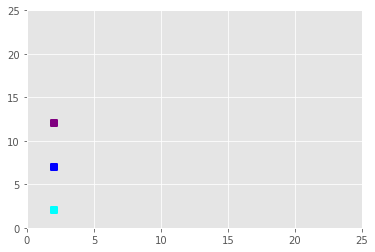

In [ ]:
plt.xlim(0, 25)
plt.ylim(0, 25)
color=["cyan","blue","purple","olive","pink","yellow"]
for i in range(ANTENNA_N):
  plt.scatter(x[i], y[i], color=color[i], linewidths =2 ,marker ="s")

plt.show()

assume that power adds up (SNR) -> reward 
qtable -> add the positions of new antenna and actions 
3 antennas optimization all area 


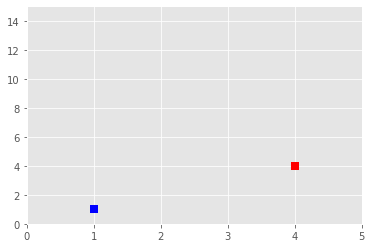

In [ ]:



valuex1=[1,1,1,1]
value1y=[1,1,1,1]
valuex2=[4,4,4,4]
valuey2=[4,4,4,4]
#addedvaluex=[3,3,3,3]
#addedvaluey=[3,3,3,3]
#print(addedvaluex(1))
#for i in range (ANTENNA_N):
 #   valuex2(i)+=addedvaluex(i)
  #  valuey2(i)=addedvaluey(i)
plt.xlim(0, SIZE_H)
plt.ylim(0, SIZE_W)
plt.scatter(valuex1, value1y, color= "blue", linewidths =2 ,marker ="s")
plt.scatter(valuex2, valuey2, color= "red", linewidths =2 ,marker ="s")
plt.show()



1, 0
1


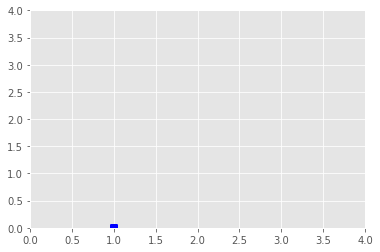

1, 0
1


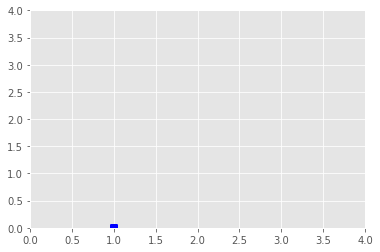

1, 0
1


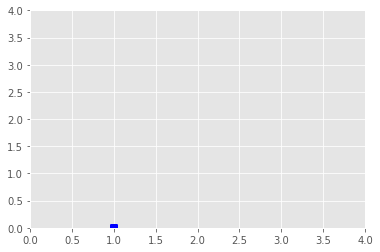

1, 0
1


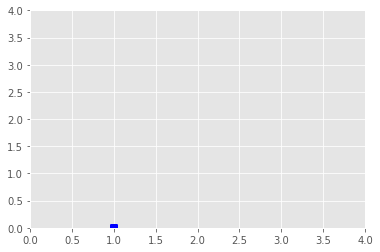

1, 0
1


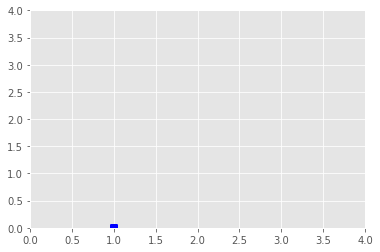

1, 0
1


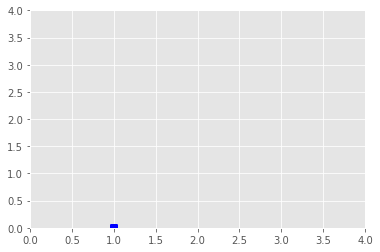

1, 0
1


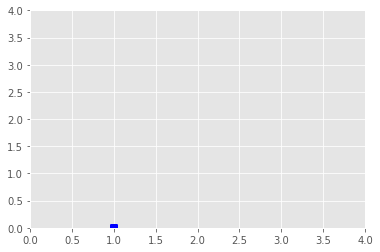

1, 0
1


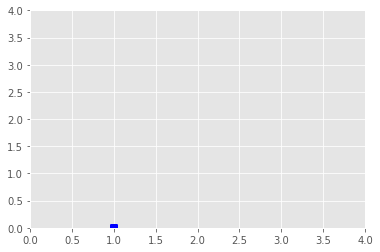

1, 0
1


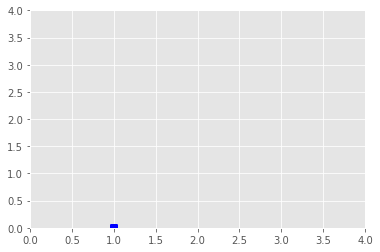

1, 0
1


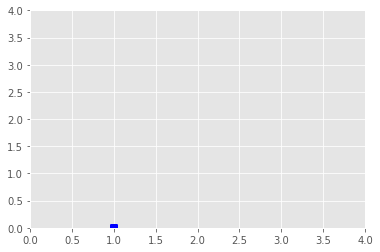

In [ ]:
#looping on q_table 
#antenna Tracing qtable
xval=[1,1,1,1]
yval=[0,0,1,1,1]
AntTest2=antenna()
AntTest2.x=xval[0]
AntTest2.y=yval[0]
for i in range(10):
   print(AntTest2)
   actionx = np.argmax(q_table[AntTest2.x][AntTest2.y])
   print(actionx)
   AntTest2.action(actionx)
   plt.scatter(AntTest2.x,AntTest2.y, color= "blue", linewidths =2 ,marker ="s")
   plt.xlim(0, 4)
   plt.ylim(0, 4)
   plt.show()
#for i in range (ANTENNA_N):
   


In [ ]:
#looping on the area 
AntTest=antenna()
EveryWhere={}
max=-200
#Move antenna Every where 
for i in range(SIZE_H):
  for j in range(SIZE_W):
    AntTest.x =i
    AntTest.y = j
    AvgSnr=calSNRlow(measureSNR(AntTest,SIZE_H,SIZE_W,type="omnidirectionnel"))
    if AvgSnr>max:
      max=AvgSnr
    list_=[AntTest.x,AntTest.y,AvgSnr]
    EveryWhere[AvgSnr]=[AntTest.x,AntTest.y]
print(max,EveryWhere[max])
print(EveryWhere)
## x,y,meanSNR   

6.574771173504353e-08 [2, 7]
{2.9763886541771717e-08: [4, 14], 4.515384632255919e-08: [0, 1], 4.612303347568145e-08: [4, 12], 4.632134676431175e-08: [0, 3], 4.638422365880389e-08: [0, 10], 4.640875572532242e-08: [4, 9], 4.641879334373908e-08: [4, 6], 4.64215679237081e-08: [4, 7], 4.6418793343739076e-08: [4, 8], 4.640875572532241e-08: [4, 5], 4.632134676431174e-08: [4, 11], 4.6123033475681444e-08: [0, 12], 4.5153846322559185e-08: [4, 13], 2.9763886541771714e-08: [0, 14], 4.5097858430365164e-08: [3, 14], 6.299808794092655e-08: [3, 13], 6.426127274950783e-08: [3, 12], 6.451417321146406e-08: [3, 11], 6.459105081470001e-08: [3, 10], 6.46199732460821e-08: [1, 5], 6.463151401679431e-08: [1, 6], 6.463466396342379e-08: [3, 7], 6.463151401679434e-08: [3, 6], 6.461997324608212e-08: [3, 9], 6.426127274950784e-08: [3, 2], 4.509785843036516e-08: [1, 14], 4.587128009214689e-08: [2, 0], 6.401596768285661e-08: [2, 1], 6.534907104303109e-08: [2, 2], 6.561987417472369e-08: [2, 3], 6.570179739893754e-08: 